<center><h1>IHX</h1></center> 
<center><h1>Task-4 : Statistical Analysis on Medical Claims</h1></center> 

In [30]:
%%time
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import re

from math import sqrt
import statsmodels.api as sm
from statsmodels.stats.weightstats import ztest as ztest
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split 
import warnings

warnings.filterwarnings('ignore')

Wall time: 0 ns


### 1. Read the Data

In [31]:
# IC2 DB
file_path =r'./Data/'
raw_df = pd.read_csv(os.path.join(file_path,'sample_claim_data_for_handson.csv'))
raw_df

,benefage,lenghtofstay,poltype,roomcategory,ailmentcode,clmamount,clmapprovedamt
0,51,7,Individual,General Ward (Economy Ward),E04,192910,69413
1,27,3,Group,Room Not Specified / Not Applicable,K85,8501,7201
2,44,70,Group,Day care,G35,136679,108104
3,27,2,Group,Sharing Ward (Semiprivate / Multibed Ward),G40,10955,10520
4,63,2,Individual,Room Not Specified / Not Applicable,S52,33466,33041
...,...,...,...,...,...,...,...
38040,25,3,Group,Single Ward ( Private / Special / Executive Ward),O82,60771,50000
38041,51,1,Group,Day care,H25,25000,25000
38042,36,5,Individual,General Ward (Economy Ward),A01.00,46930,41315
38043,14,3,Individual,General Ward (Economy Ward),A90.0,19876,15042


In [32]:
# find the percentage of claim amt approved
l =[]
for i in range(len(raw_df)):
    l.append(float('{:.2f}'.format(raw_df['clmapprovedamt'].iloc[i]/raw_df['clmamount'].iloc[i]*100)))
raw_df['clmamtapproved_per'] = l
raw_df[['clmamount','clmapprovedamt','clmamtapproved_per']].head(8)

,clmamount,clmapprovedamt,clmamtapproved_per
0,192910,69413,35.98
1,8501,7201,84.71
2,136679,108104,79.09
3,10955,10520,96.03
4,33466,33041,98.73
5,70628,0,0.00
6,519050,200000,38.53
7,103528,103378,99.86


In [33]:
# percentage of null values
raw_df.isnull().sum()/len(raw_df)*100

benefage              0.0
lenghtofstay          0.0
poltype               0.0
roomcategory          0.0
ailmentcode           0.0
clmamount             0.0
clmapprovedamt        0.0
clmamtapproved_per    0.0
dtype: float64

### 2. Find the Anomalies
> Anomaly = clmamtapproved_per > 100%

In [35]:
print('percentage anomalies: {:.2f} %'.format(len(raw_df['clmamtapproved_per'].where(raw_df['clmamtapproved_per']>100).dropna())/len(raw_df)*100))

percentage anomalies: 0.04 %


In [6]:
# anomalous records
print('Number of records with anomolies:',len(raw_df.where(raw_df['clmamtapproved_per']>100).dropna()))
raw_df.where(raw_df['clmamtapproved_per']>100).dropna()

Number of records with anomolies: 14


,benefage,lenghtofstay,poltype,roomcategory,ailmentcode,clmamount,clmapprovedamt,clmamtapproved_per
338,10.0,11.0,Group,General Ward (Economy Ward),A98,6864.0,10000.0,145.69
4313,47.0,2.0,Group,Single Ward ( Private / Special / Executive Ward),Q39,15444.0,30000.0,194.25
5933,48.0,8.0,Group,General Ward (Economy Ward),K35.2,142151.0,143780.0,101.15
6652,35.0,6.0,Group,Deluxe (Luxury/ Super Deluxe / Suite / Ultra S...,A90.0,14470.0,28500.0,196.96
8232,48.0,8.0,Group,General Ward (Economy Ward),K35.2,142151.0,143780.0,101.15
9445,39.0,6.0,Group,General Ward (Economy Ward),G81,10.0,4000.0,40000.00
14347,30.0,5.0,Group,Sharing Ward (Semiprivate / Multibed Ward),Z98,25118.0,60000.0,238.87
17030,26.0,5.0,Group,General Ward (Economy Ward),R50.9,19330.0,28580.0,147.85
19150,23.0,6.0,Individual,General Ward (Economy Ward),R68,25411.0,26000.0,102.32
21532,75.0,3.0,Group,Room Not Specified / Not Applicable,R11,8695.0,15000.0,172.51


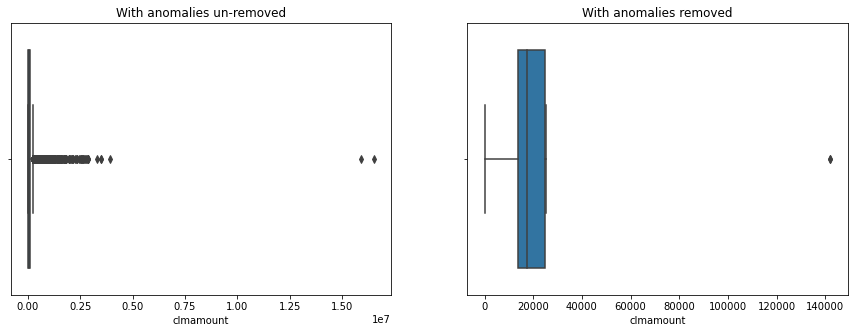

In [7]:
# checking after removing the anomalous records
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.boxplot(x=raw_df['clmamount'])
plt.title('With anomalies un-removed')

plt.subplot(1,2,2)
sns.boxplot(x=raw_df['clmamount'].where(raw_df['clmamtapproved_per']>100).dropna())
plt.title('With anomalies removed')

plt.show()
raw_df = raw_df.where(raw_df['clmamtapproved_per']<=100).dropna()

### 3. Grouping similar ailments together.
> - Step 1: Filter out all the ailments that belong to the same letter.
> - Step 2: Hypothesise if they can belong to the same group.
> - Step 3: Group together the ones that belong to the same group.

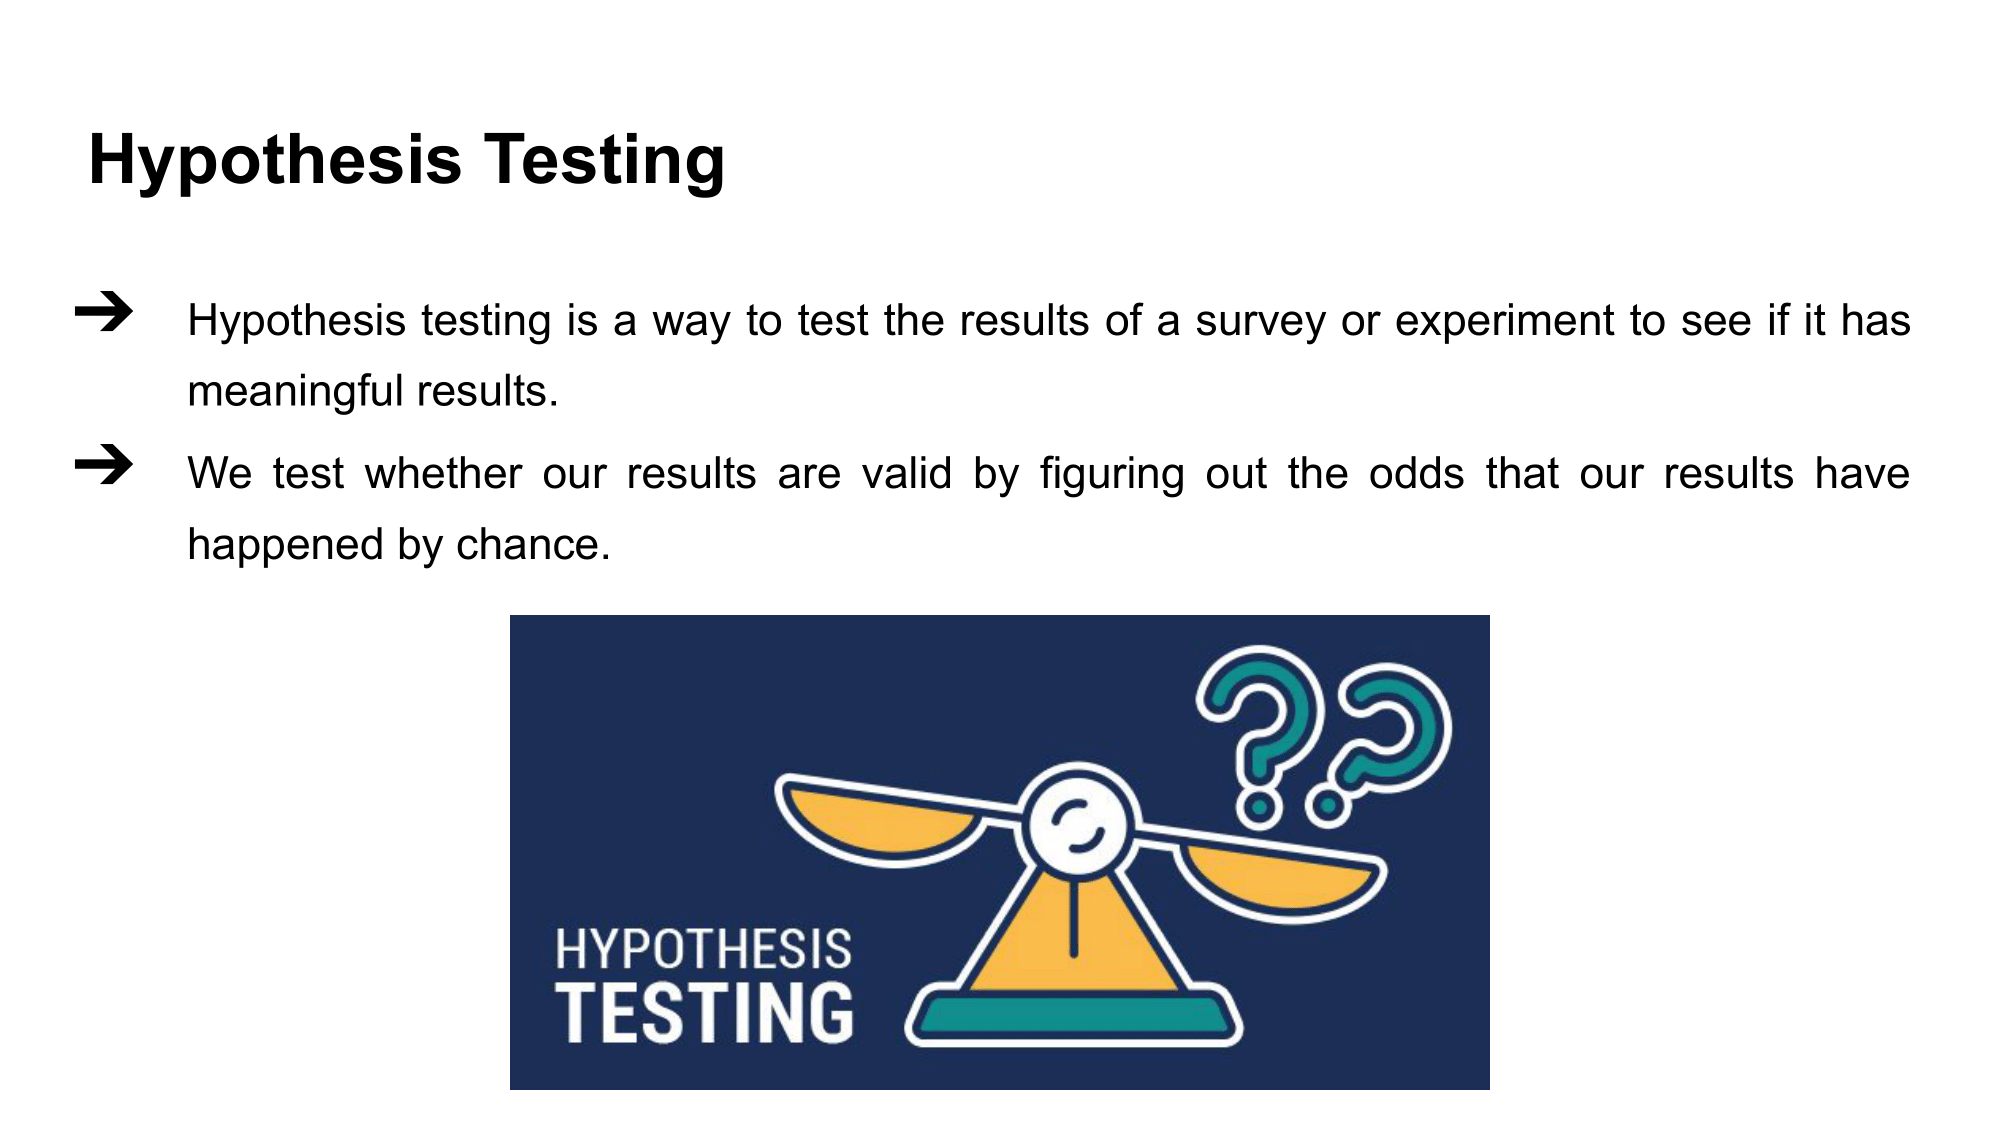

In [8]:
# Step 1: using regex to the filter the ailments.

ailment_codes =[]
for i in raw_df['ailmentcode'].unique():
    r1 = re.findall(r"^B.*",i)
    if(r1!=[]):
        ailment_codes.append(r1[0])
print(ailment_codes[:5],'......')

['B34.9', 'B51.9', 'B17', 'B50', 'B19.9'] ......


In [9]:
# creating a dataframe for the filtered ailments

b_ailment_df = pd.DataFrame()
for i in range(len(ailment_codes)):
    temp_df = raw_df.where(raw_df['ailmentcode'] == ailment_codes[i]).dropna()
    b_ailment_df = pd.concat([b_ailment_df,temp_df])
print(len(b_ailment_df))

549


In [10]:
# Unique number of ailments present in the dataframe

b_ailment_df['ailmentcode'].nunique() #86

86

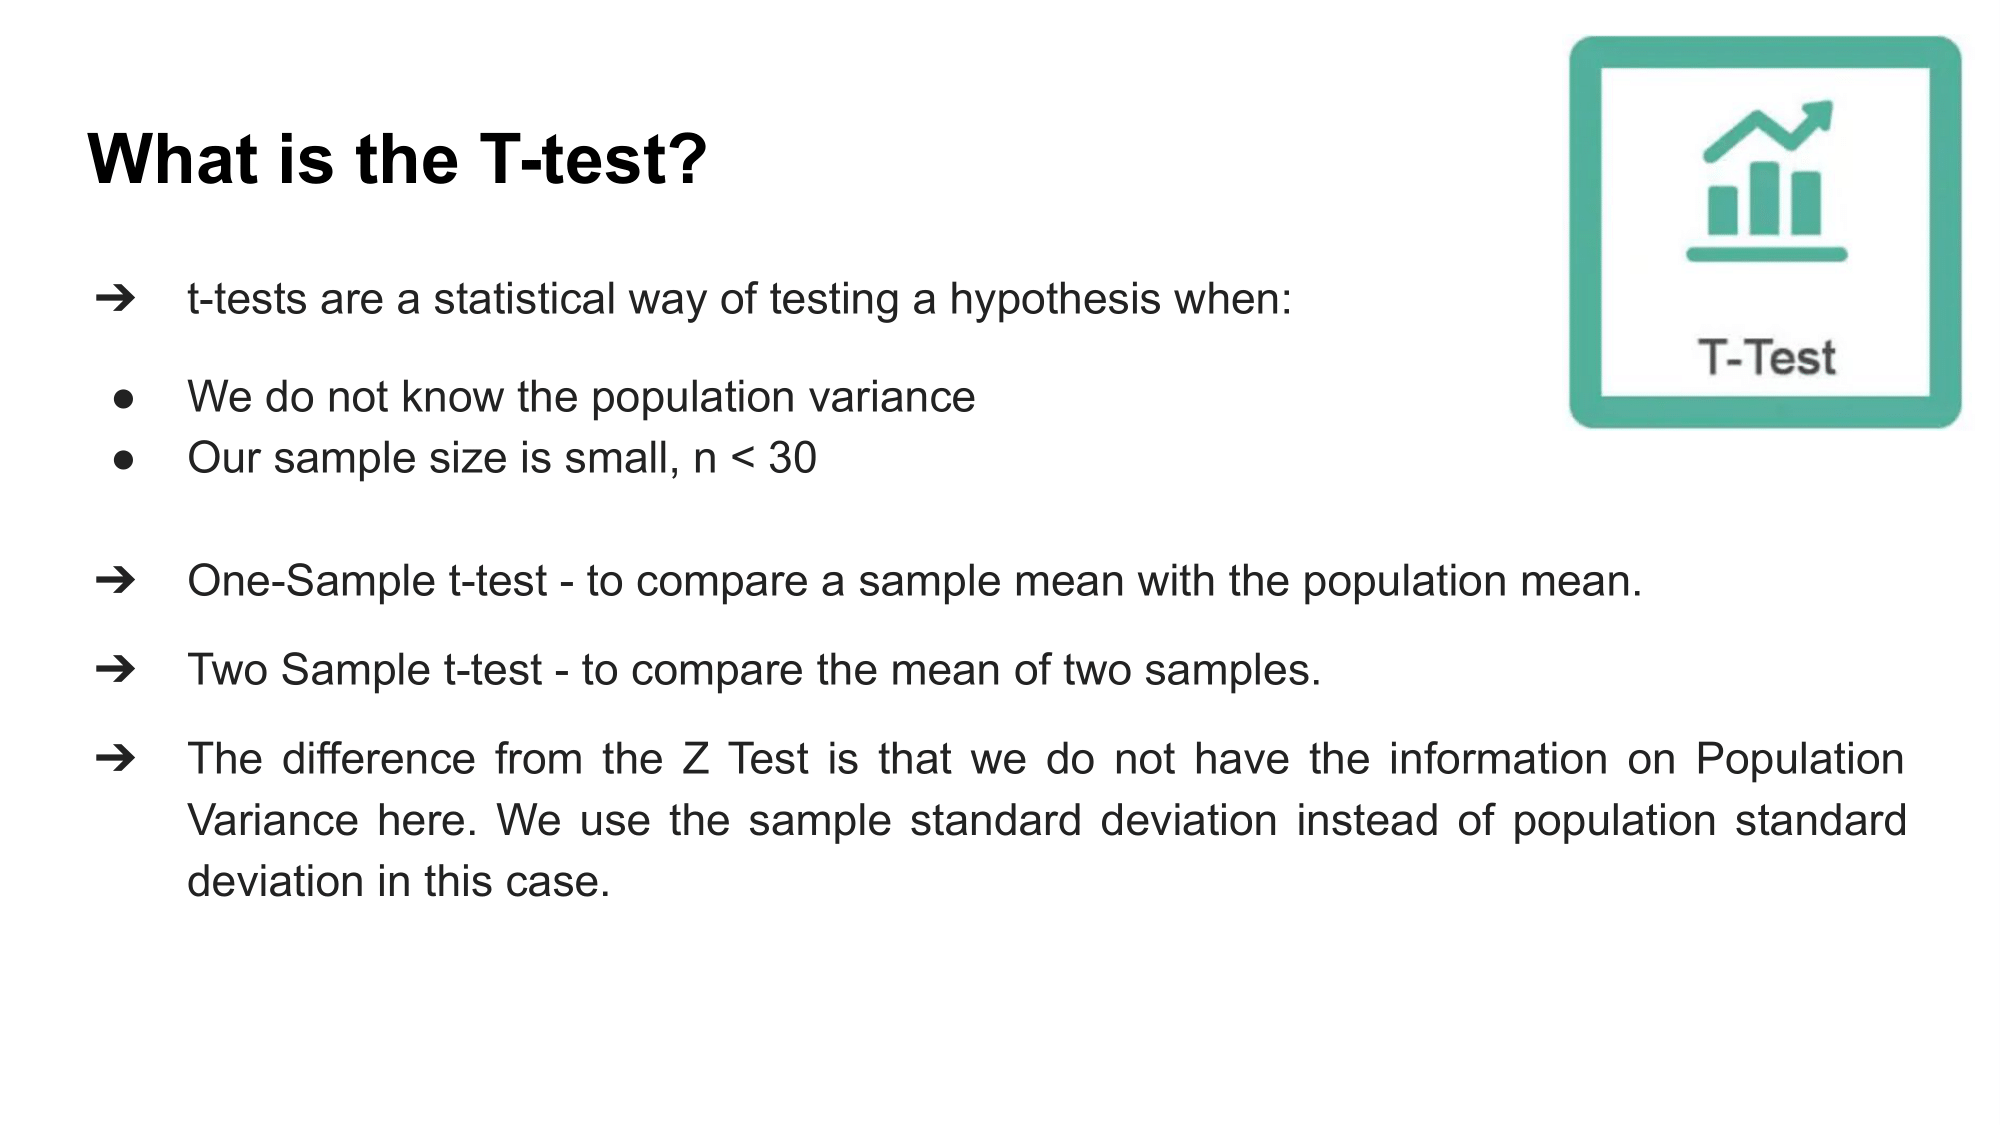

In [11]:
# 'B01', 'B02'

b01 = b_ailment_df[b_ailment_df['ailmentcode']=='B01']['clmamount']
b02 = b_ailment_df[b_ailment_df['ailmentcode']=='B02']['clmamount']

print('B01: ',b01.values)
print('B02: ',b02.values, end='\n\n')

# T-test: [2 sample t-test]

t_value,p_value=stats.ttest_ind(b01,b02)
print('- Test statistic is %f'%float("{:.6f}".format(t_value)))
print('- p-value for two tailed test is %f'%p_value, end='\n\n')
alpha = 0.05

print('- Mean for B01: {:.2f}'.format(b01.mean()))
print('- Mean for B02: {:.2f}'.format(b02.mean()),end='\n\n')

if(p_value>=alpha):
    print('Conclusion:','Since the p-value: {:.2f} > or = alpha: {:.2f}, We fail to reject the null hypothesis.'.format(p_value,alpha),sep='\n')
else:
    print('Since the p-value: {:.2f} < alpha: {:.2f}, We reject the null hypothesis.'.format(p_value,alpha))

B01:  [14436. 56561. 12029. 12196. 32195.  9612. 89679. 45667.]
B02:  [25842. 49657. 32661. 30867.]

- Test statistic is -0.047305
- p-value for two tailed test is 0.963202

- Mean for B01: 34046.88
- Mean for B02: 34756.75

Conclusion:
Since the p-value: 0.96 > or = alpha: 0.05, We fail to reject the null hypothesis.


In [12]:
# 'B01', 'B74'

b01 = b_ailment_df[b_ailment_df['ailmentcode']=='B01']['clmamount']
b74 = b_ailment_df[b_ailment_df['ailmentcode']=='B74']['clmamount']

print('B01: ',b01.values)
print('B74: ',b74.values, end='\n\n')

# T-test:

t_value,p_value=stats.ttest_ind(b01,b74)
print('- Test statistic is %f'%float("{:.6f}".format(t_value)))
print('- p-value for two tailed test is %f'%p_value, end='\n\n')
alpha = 0.05

print('- Mean for B01: {:.2f}'.format(b01.mean()))
print('- Mean for B74: {:.2f}'.format(b74.mean()),end='\n\n')

if(p_value>=alpha):
    print('Conclusion:','Since the p-value: {:.2f} > or = alpha: {:.2f}, We fail to reject the null hypothesis.'.format(p_value,alpha),sep='\n')
else:
    print('Since the p-value: {:.2f} < alpha: {:.2f}, We reject the null hypothesis.'.format(p_value,alpha))

B01:  [14436. 56561. 12029. 12196. 32195.  9612. 89679. 45667.]
B74:  [ 14800.  52792.  17606.  42123.  38008.  41540.   8055.  13570. 227259.]

- Test statistic is -0.639542
- p-value for two tailed test is 0.532117

- Mean for B01: 34046.88
- Mean for B74: 50639.22

Conclusion:
Since the p-value: 0.53 > or = alpha: 0.05, We fail to reject the null hypothesis.


#### Insights:
> -  The means and variance are significantly different for both the ailments yet according to the t-test they belong to the same population. 
> - We can't use T-test in this case to identify common ailments as the sample size to determine the same is very low.

#### Solution:
> - We can assume that the ailments are closely related as they are masked accordingly {according to the database}

### 4. Rolling up all the aliment values to its initial letter.

In [13]:
# Segregating the records
# 65 - 90 : A - Z

def convert_alpha(character, df):
    ailment_codes =[]
    for i in df['ailmentcode'].unique():
        r1 = re.findall(r"^"+character+".*",i)
        if(r1!=[]):
            ailment_codes.append(r1[0])
    temp_df = df.where(df['ailmentcode'].isin(ailment_codes)).dropna()

    n_col = list(character*len(temp_df))
    temp_df['ailmentcode'] = n_col
    return temp_df

processed_df = pd.DataFrame()
k=0
for i in range(65,91):
    print(chr(i), end='\t')
    temp = convert_alpha(chr(i),raw_df)
    if(k==0):
        processed_df = temp
        k+=1
    elif(k==1):
        processed_df = pd.concat([processed_df,temp], axis=0)
    print(len(temp), end = '\t')

print('\n\n'+'Total number of records:',len(processed_df))

A	4239	B	549	C	2021	D	919	E	733	F	68	G	681	H	2317	I	3635	J	2576	K	3815	L	537	M	1838	N	3914	O	3620	P	624	Q	124	R	2698	S	2384	T	272	U	0	V	80	W	26	X	8	Y	8	Z	345	

Total number of records: 38031


### 5. Further grouping the records based on the ailments
> To reduce the number of extra columns while creating dummy columns for the same.

In [14]:
# X and Y
# Example to illustrate what we are trying to achieve:
#  - we would want to see all the ailments that are closely related and would want to further group them.

cols = ['benefage','lenghtofstay','clmamount']
flag = 0
for i in cols:
    print('Column in consideration:',i)
    X = processed_df[processed_df['ailmentcode']=='X'][i]
    Y = processed_df[processed_df['ailmentcode']=='Y'][i]

    print('X: ',X.values)
    print('Y: ',Y.values, end='\n\n')

    # T-test:
    t_value,p_value=stats.ttest_ind(X,Y)
    alpha = 0.05

    if(p_value>=alpha):
        print('Conclusion:','Since the p-value: {:.2f} > or = alpha: {:.2f}, We fail to reject the null hypothesis.'.format(p_value,alpha),sep='\n',end='\n\n')
        flag+=1
    else:
        print('Since the p-value: {:.2f} < alpha: {:.2f}, We reject the null hypothesis.'.format(p_value,alpha),end='\n\n')
    print('----------------------------------------------------------------------------')
print('Flags :',flag)
if(flag>1):
    print('Can be grouped together')
else:
    print("Can't be grouped together")

Column in consideration: benefage
X:  [62.  2. 42. 41. 83. 23. 53.  4.]
Y:  [47. 46. 35. 49. 56.  0. 57. 54.]

Conclusion:
Since the p-value: 0.73 > or = alpha: 0.05, We fail to reject the null hypothesis.

----------------------------------------------------------------------------
Column in consideration: lenghtofstay
X:  [5. 4. 5. 2. 2. 3. 6. 2.]
Y:  [11.  4.  2.  4. 39.  1.  3.  3.]

Conclusion:
Since the p-value: 0.31 > or = alpha: 0.05, We fail to reject the null hypothesis.

----------------------------------------------------------------------------
Column in consideration: clmamount
X:  [112551.  13589.  37867.  29828.  20325.  32390.   1947.  13525.]
Y:  [653964. 270547.  16984.  16427.  14604.   2800.  11953.  17882.]

Conclusion:
Since the p-value: 0.28 > or = alpha: 0.05, We fail to reject the null hypothesis.

----------------------------------------------------------------------------
Flags : 3
Can be grouped together


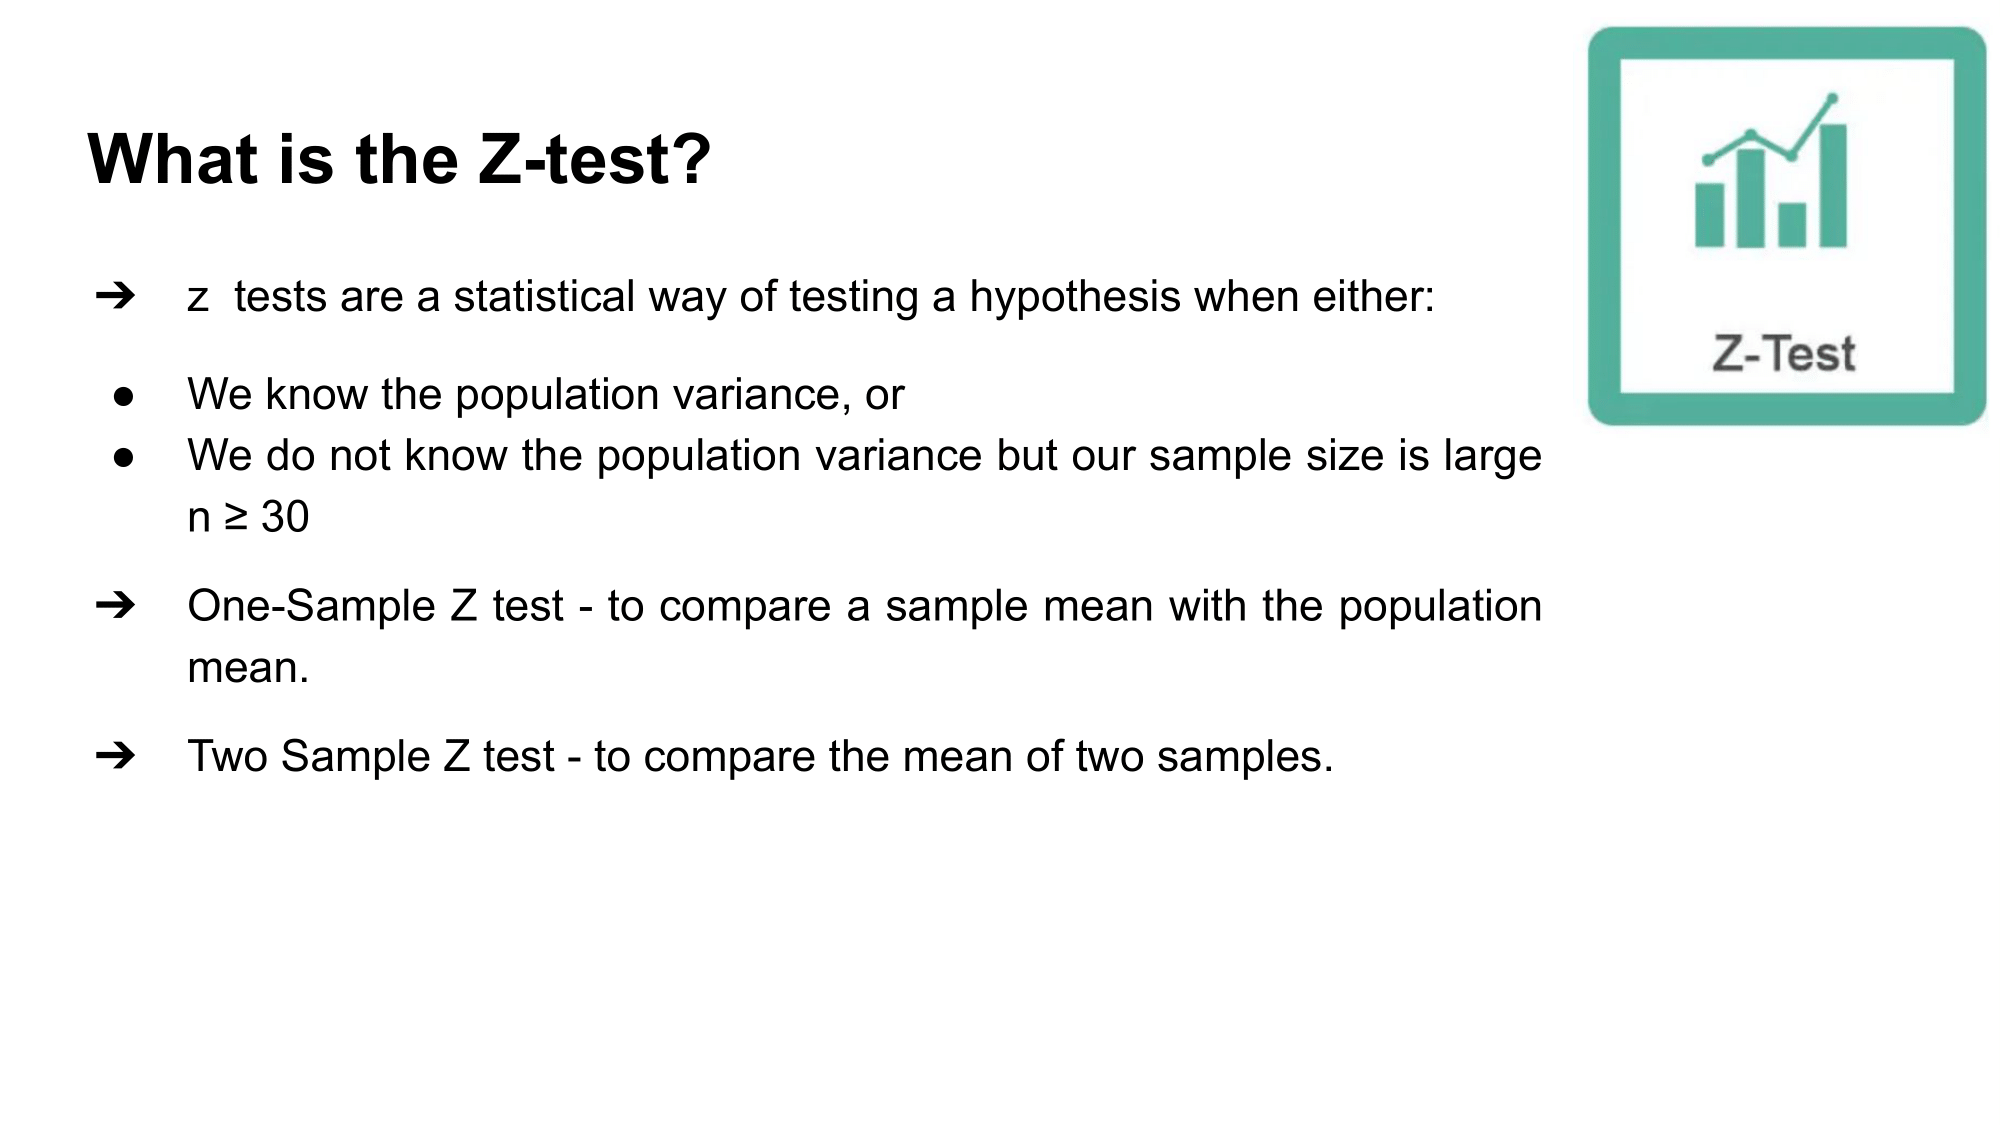

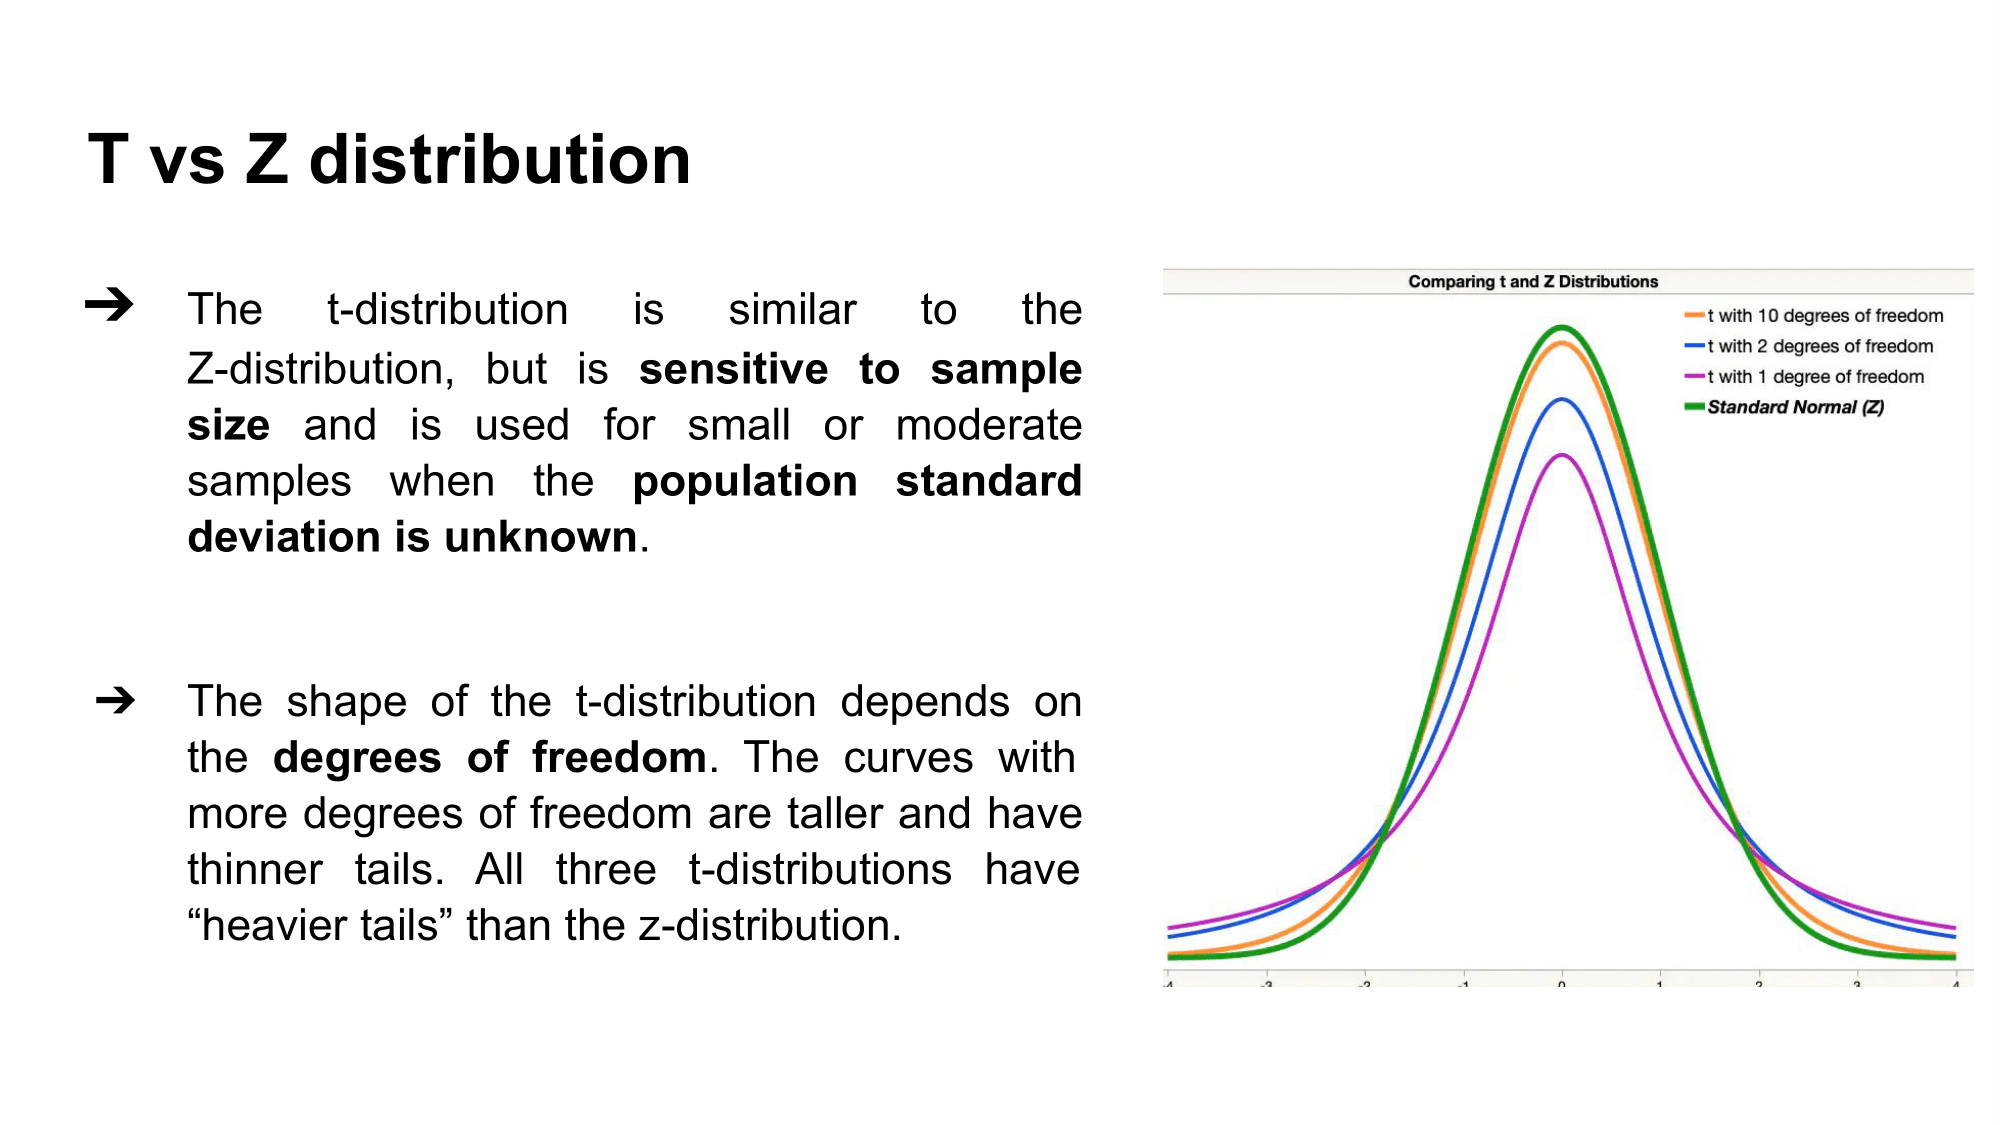

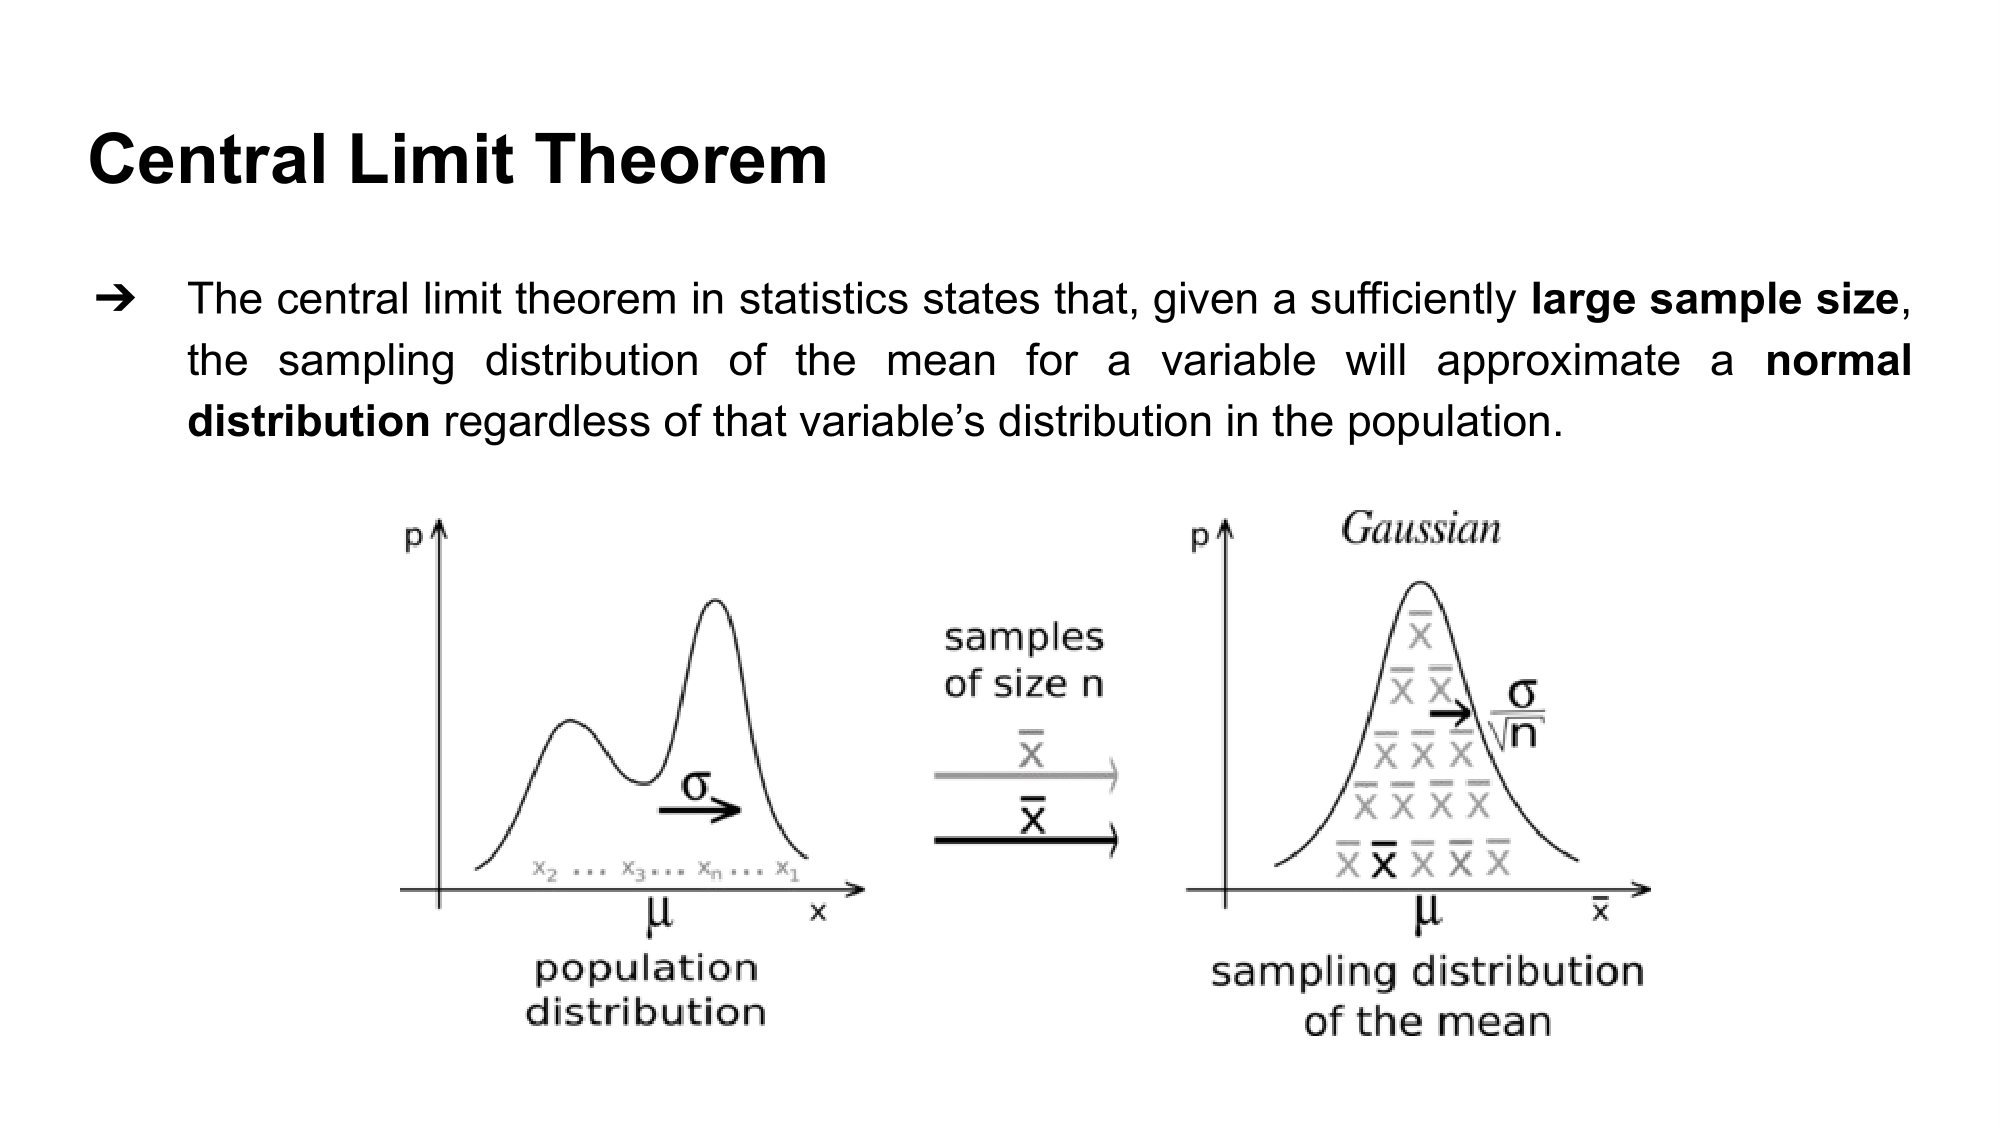

In [15]:
%%time
# Not to be kept in the code [Just for reference]
def t_test_res(g1, g2, alpha=0.05):
    t_value,p_value=stats.ttest_ind(g1,g2)
    if(p_value>=alpha):
        return True
    else:
        return False

def z_test_2tail(g1, g2, alpha = 0.05):
    p_value=ztest(g1,g2)[1]
    if(p_value <= -alpha/2):
        return True
    elif(p_value >= alpha/2):
        return True
    else:
        return False
    
ailment_codes = list(processed_df['ailmentcode'].unique())
cols = ['benefage','lenghtofstay','clmamount']
groups = {}
for k in range(len(ailment_codes)):

    groups[ailment_codes[k]] = []
    for i in range(len(ailment_codes)):
        flag = 0
        for j in cols:
            g1 = processed_df[processed_df['ailmentcode']==ailment_codes[k]][j]
            g2 = processed_df[processed_df['ailmentcode']==ailment_codes[i]][j]
            
            max_length = max(len(g1),len(g2))
            if(len(g1)>=0.1*max_length and len(g2)>=0.1*max_length):
                # T-test:
                if(len(g1)<30 and len(g2)<30):
                    if(t_test_res(g1,g2)==True):
                        flag+=1

                # Z-test
                else:
                    if(z_test_2tail(g1,g2)==True):
                        flag+=1
            else:
                continue
        if(flag>1):
            groups[ailment_codes[k]].append(ailment_codes[i])

n_groups = {}
for i in groups.keys():
    n_groups[i]=[]
    for j in groups[i]:
        if(i==j):
            continue
        else:
            n_groups[i].append(j)
    if(n_groups[i]==[]):
        n_groups.pop(i)
n_groups

Wall time: 12.6 s


{'A': ['B'],
 'B': ['A', 'R'],
 'C': ['G', 'T'],
 'D': ['G', 'L', 'Q', 'S', 'T'],
 'E': ['T', 'V', 'Z'],
 'F': ['P', 'T', 'V', 'W', 'X', 'Y', 'Z'],
 'G': ['C', 'D', 'N', 'Q', 'T', 'V'],
 'J': ['L', 'T', 'Z'],
 'K': ['N'],
 'L': ['D', 'J', 'N', 'V', 'Z'],
 'N': ['G', 'K', 'L'],
 'O': ['R'],
 'P': ['F'],
 'Q': ['D', 'G', 'T', 'V', 'W'],
 'R': ['B', 'O'],
 'S': ['D', 'T'],
 'T': ['C', 'D', 'E', 'F', 'G', 'J', 'Q', 'S', 'V', 'Z'],
 'V': ['E', 'F', 'G', 'L', 'Q', 'T', 'W', 'X', 'Y', 'Z'],
 'W': ['F', 'Q', 'V', 'X', 'Y'],
 'X': ['F', 'V', 'W', 'Y'],
 'Y': ['F', 'V', 'W', 'X'],
 'Z': ['E', 'F', 'J', 'L', 'T', 'V']}

In [16]:
%%time

# Making the groups
groups = []
residual = ailment_codes
for k in ailment_codes:
    inner_group = [k]
    residual = list(set(residual).difference(set(inner_group)))
    if(residual==[]):
        break
    else:
        for i in residual:
            flag = 0
            for j in cols:
                g1 = processed_df[processed_df['ailmentcode']==k][j]
                g2 = processed_df[processed_df['ailmentcode']==i][j]

                max_length = max(len(g1),len(g2))
                if(len(g1)>=0.1*max_length and len(g2)>=0.1*max_length):
                    # T-test:
                    if(len(g1)<30 and len(g2)<30):
                        if(t_test_res(g1,g2)==True):
                            flag+=1

                    # Z-test
                    else:
                        if(z_test_2tail(g1,g2)==True):
                            flag+=1
                else:
                    continue
            if(flag>1):
                inner_group.append(i)
    
    residual = list(set(residual).difference(set(inner_group)))
    groups.append(inner_group)

groups
# filtering out the duplicates [on visual inspection]
final_group =[]
for i in groups:
    if i in [['N'],['L']]:
        continue
    else:
        final_group.append(i)
# replacing B -> O
final_group[1][0] = 'O'

# Removing G due to duplicate
final_group[6].pop(0)

d_final_group = {}
for i in range(len(final_group)):
    d_final_group[i] = final_group[i]
d_final_group

Wall time: 2.19 s


{0: ['A', 'B'],
 1: ['O', 'R'],
 2: ['C', 'T', 'G'],
 3: ['D', 'S', 'Q', 'L'],
 4: ['E', 'V', 'Z'],
 5: ['F', 'Y', 'W', 'P', 'X'],
 6: ['N'],
 7: ['H'],
 8: ['I'],
 9: ['J'],
 10: ['K'],
 11: ['M']}

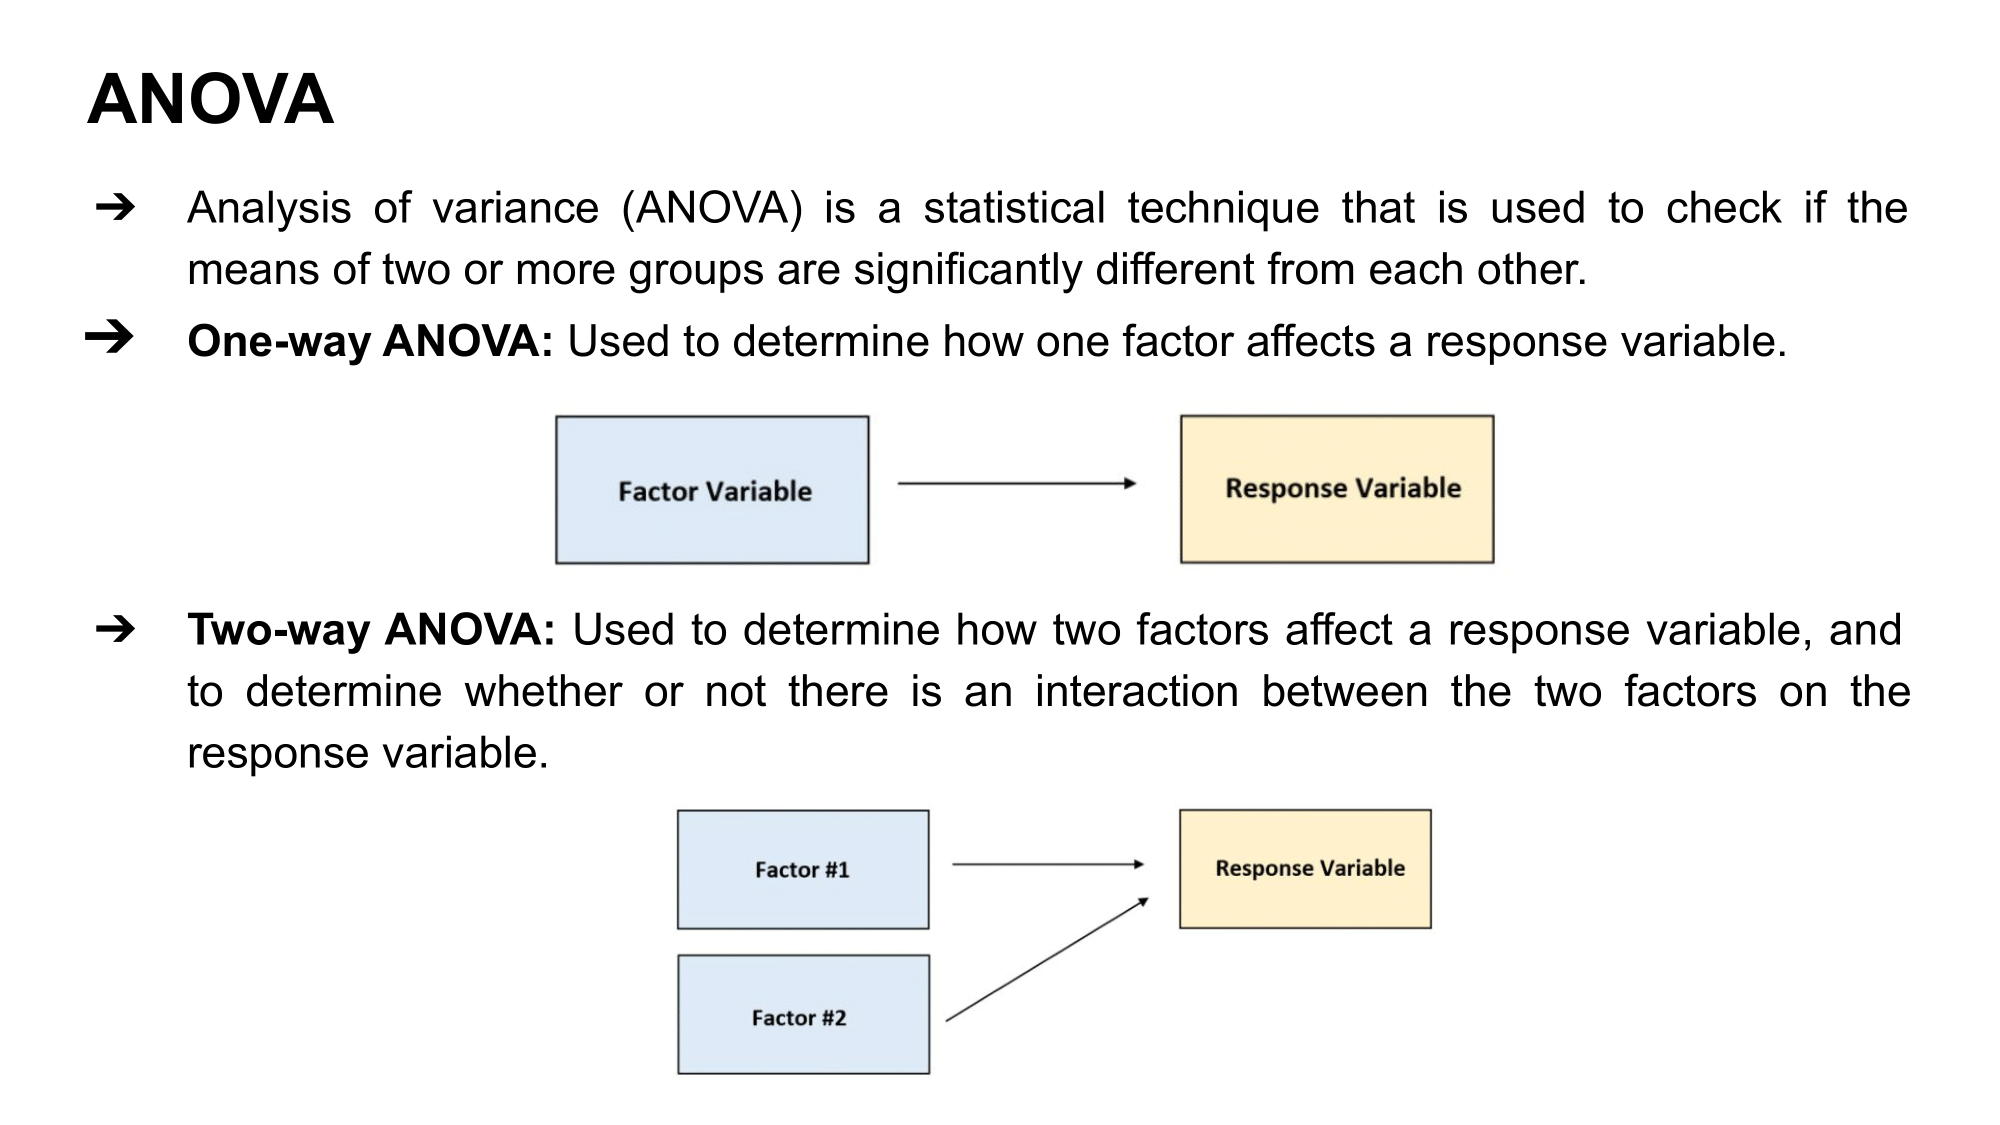

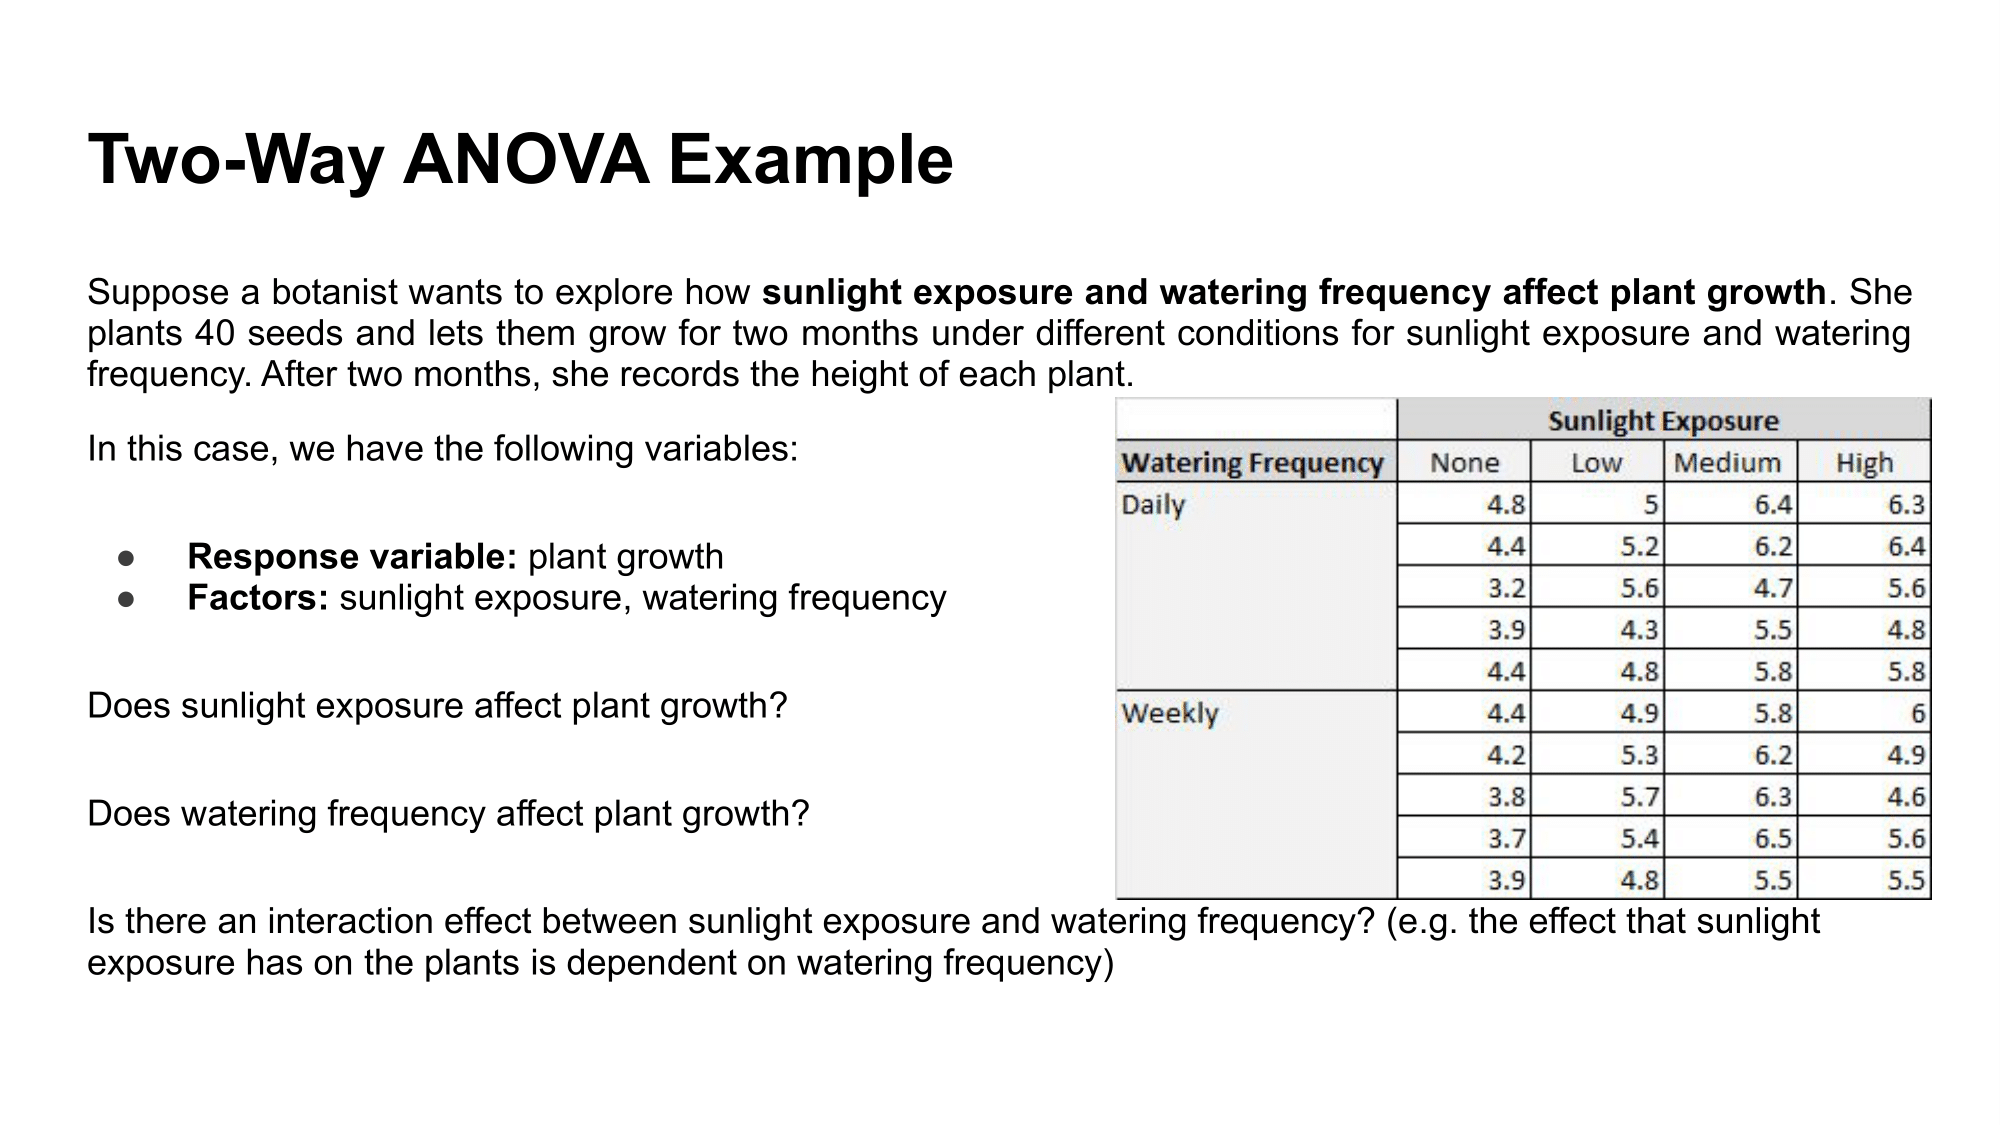

### 6. Cross-verifying our groupings using ANOVA

In [17]:
# Test for Anova:

def hypothesis_test(p_value, alpha=0.05):
    if(p_value>=alpha):
        return('H0 accepted')
    else:
        return('H0 rejected')
    
# -----------------------------------

anova_test_groups = {}
for i in d_final_group.keys():
    if(len(d_final_group[i])>2):
        anova_test_groups[i]=d_final_group[i]

for i in anova_test_groups.keys():
    flag = 0
    print('Group_{} :'.format(i),anova_test_groups[i],sep='\t')
    for j in cols:
        print(j,':',end='\t')
        g1 = processed_df[j].where(processed_df['ailmentcode']==anova_test_groups[i][0]).dropna()
        g2 = processed_df[j].where(processed_df['ailmentcode']==anova_test_groups[i][1]).dropna()
        g3 = processed_df[j].where(processed_df['ailmentcode']==anova_test_groups[i][2]).dropna()
        
        if(len(anova_test_groups[i])==3):
            f_value, p_value = stats.f_oneway(g1,g2,g3)
            return_val = hypothesis_test(p_value)
            print(return_val,'{:.4f}'.format(p_value))
            if(return_val == 'H0 accepted'):
                flag+=1
                
        elif(len(anova_test_groups[i])==4):
            g4 = processed_df[j].where(processed_df['ailmentcode']==anova_test_groups[i][3]).dropna()
            f_value, p_value = stats.f_oneway(g1,g2,g3,g4)
            return_val = hypothesis_test(p_value)
            print(return_val,'{:.4f}'.format(p_value))
            if(return_val == 'H0 accepted'):
                flag+=1
                
        elif(len(anova_test_groups[i])==5):
            g4 = processed_df[j].where(processed_df['ailmentcode']==anova_test_groups[i][3]).dropna()
            g5 = processed_df[j].where(processed_df['ailmentcode']==anova_test_groups[i][4]).dropna()
            f_value, p_value = stats.f_oneway(g1,g2,g3,g4,g5)
            return_val = hypothesis_test(p_value)
            print(return_val,'{:.4f}'.format(p_value))
            if(return_val == 'H0 accepted'):
                flag+=1
    print()
    print('Total number of flags: ',flag)
    if(flag>1):
        print('Statistically Grouped')
    else:
        print('Wrongly Grouped')
    print('---------------------------------------------------------------',end='\n\n')

Group_2 :	['C', 'T', 'G']
benefage :	H0 rejected 0.0000
lenghtofstay :	H0 accepted 0.1002
clmamount :	H0 accepted 0.1078

Total number of flags:  2
Statistically Grouped
---------------------------------------------------------------

Group_3 :	['D', 'S', 'Q', 'L']
benefage :	H0 rejected 0.0000
lenghtofstay :	H0 accepted 0.1818
clmamount :	H0 rejected 0.0029

Total number of flags:  1
Wrongly Grouped
---------------------------------------------------------------

Group_4 :	['E', 'V', 'Z']
benefage :	H0 rejected 0.0000
lenghtofstay :	H0 accepted 0.7659
clmamount :	H0 accepted 0.2036

Total number of flags:  2
Statistically Grouped
---------------------------------------------------------------

Group_5 :	['F', 'Y', 'W', 'P', 'X']
benefage :	H0 rejected 0.0000
lenghtofstay :	H0 accepted 0.1200
clmamount :	H0 accepted 0.4371

Total number of flags:  2
Statistically Grouped
---------------------------------------------------------------



In [18]:
# T-Test:
# We need to run a t-test for each combination to identify which ailment is wrongly grouped.

print('Test for all the values in Group_{} : {}'.format(3, anova_test_groups[3]),end='\n\n')  
for i in range(len(anova_test_groups[3])-1):
    for j in range(i+1,len(anova_test_groups[3])):
        flag = 0 
        print('Test between {} and {} :'.format(anova_test_groups[3][i],anova_test_groups[3][j]), end='\t')
        for k in cols:
            g1 = processed_df[k].where(processed_df['ailmentcode']==anova_test_groups[3][i]).dropna()
            g2 = processed_df[k].where(processed_df['ailmentcode']==anova_test_groups[3][j]).dropna()
            test_val = t_test_res(g1,g2)
            if(test_val==True):
                flag+=1
        print(' flag: ',flag,end =' \t')
        if(flag>1):
            print('Correctly Grouped', end='\n')
        else:
            print('Wrongly Grouped', end='\n')

# Since we see that L is the ailment we have a problem with, we will take it out of the group.

Test for all the values in Group_3 : ['D', 'S', 'Q', 'L']

Test between D and S :	 flag:  2 	Correctly Grouped
Test between D and Q :	 flag:  2 	Correctly Grouped
Test between D and L :	 flag:  2 	Correctly Grouped
Test between S and Q :	 flag:  2 	Correctly Grouped
Test between S and L :	 flag:  0 	Wrongly Grouped
Test between Q and L :	 flag:  1 	Wrongly Grouped


In [19]:
# 'L': ['D', 'J', 'N', 'V', 'Z']
# 'L': ['J', 'N']
# Since J and N are not related and isolated groups, we are going to choose the one which has a better p_value for grouping

for k in ['J', 'N']:
    print('L and {}'.format(k))
    flag = 0
    for i in cols:
        g1 = processed_df[i].where(processed_df['ailmentcode']=='L').dropna()
        g2 = processed_df[i].where(processed_df['ailmentcode']==k).dropna()
        test_val = t_test_res(g1,g2)
        t_stat, p_value = t_value,p_value=stats.ttest_ind(g1,g2)
        print(i,'p_value: {:.4f}'.format(p_value),sep='\t')
        if(test_val==True):
            flag+=1
    print('flag: ',flag)
    if(flag>1):
        print ('-> Can be grouped', end='\n\n')
    else:
        print("-> Can't be grouped", end='\n\n')

L and J
benefage	p_value: 0.0000
lenghtofstay	p_value: 0.0319
clmamount	p_value: 0.1796
flag:  1
-> Can't be grouped

L and N
benefage	p_value: 0.1987
lenghtofstay	p_value: 0.6172
clmamount	p_value: 0.9304
flag:  3
-> Can be grouped



In [20]:
def create_dummy(series, group):
    dummy = []
    for i in series:
        if(i in group):
            dummy.append(1)
        else:
            dummy.append(0)
    return dummy

d_final_group[3].remove('L')
d_final_group[6].append('L')

for i in d_final_group.keys():
    processed_df['Group_'+str(i)] = create_dummy(processed_df['ailmentcode'],d_final_group[i])
processed_df.head()

,benefage,lenghtofstay,poltype,roomcategory,ailmentcode,clmamount,clmapprovedamt,clmamtapproved_per,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,Group_9,Group_10,Group_11
8,33.0,5.0,Group,Single Ward ( Private / Special / Executive Ward),A,23047.0,19747.0,85.68,1,0,0,0,0,0,0,0,0,0,0,0
12,50.0,6.0,Individual,Sharing Ward (Semiprivate / Multibed Ward),A,33062.0,0.0,0.00,1,0,0,0,0,0,0,0,0,0,0,0
16,3.0,2.0,Group,Sharing Ward (Semiprivate / Multibed Ward),A,4559.0,4370.0,95.85,1,0,0,0,0,0,0,0,0,0,0,0
18,35.0,6.0,Individual,Single Ward ( Private / Special / Executive Ward),A,24502.0,20502.0,83.67,1,0,0,0,0,0,0,0,0,0,0,0
27,31.0,3.0,Group,General Ward (Economy Ward),A,8618.0,8468.0,98.26,1,0,0,0,0,0,0,0,0,0,0,0


In [21]:
# to write the dataframe file in the csv format
processed_df.to_csv(os.path.join(file_path,'claim_data_processed.csv'))

### 7. Chi-sq. Test of independence.
> To see if the 2 categorical variables are associated

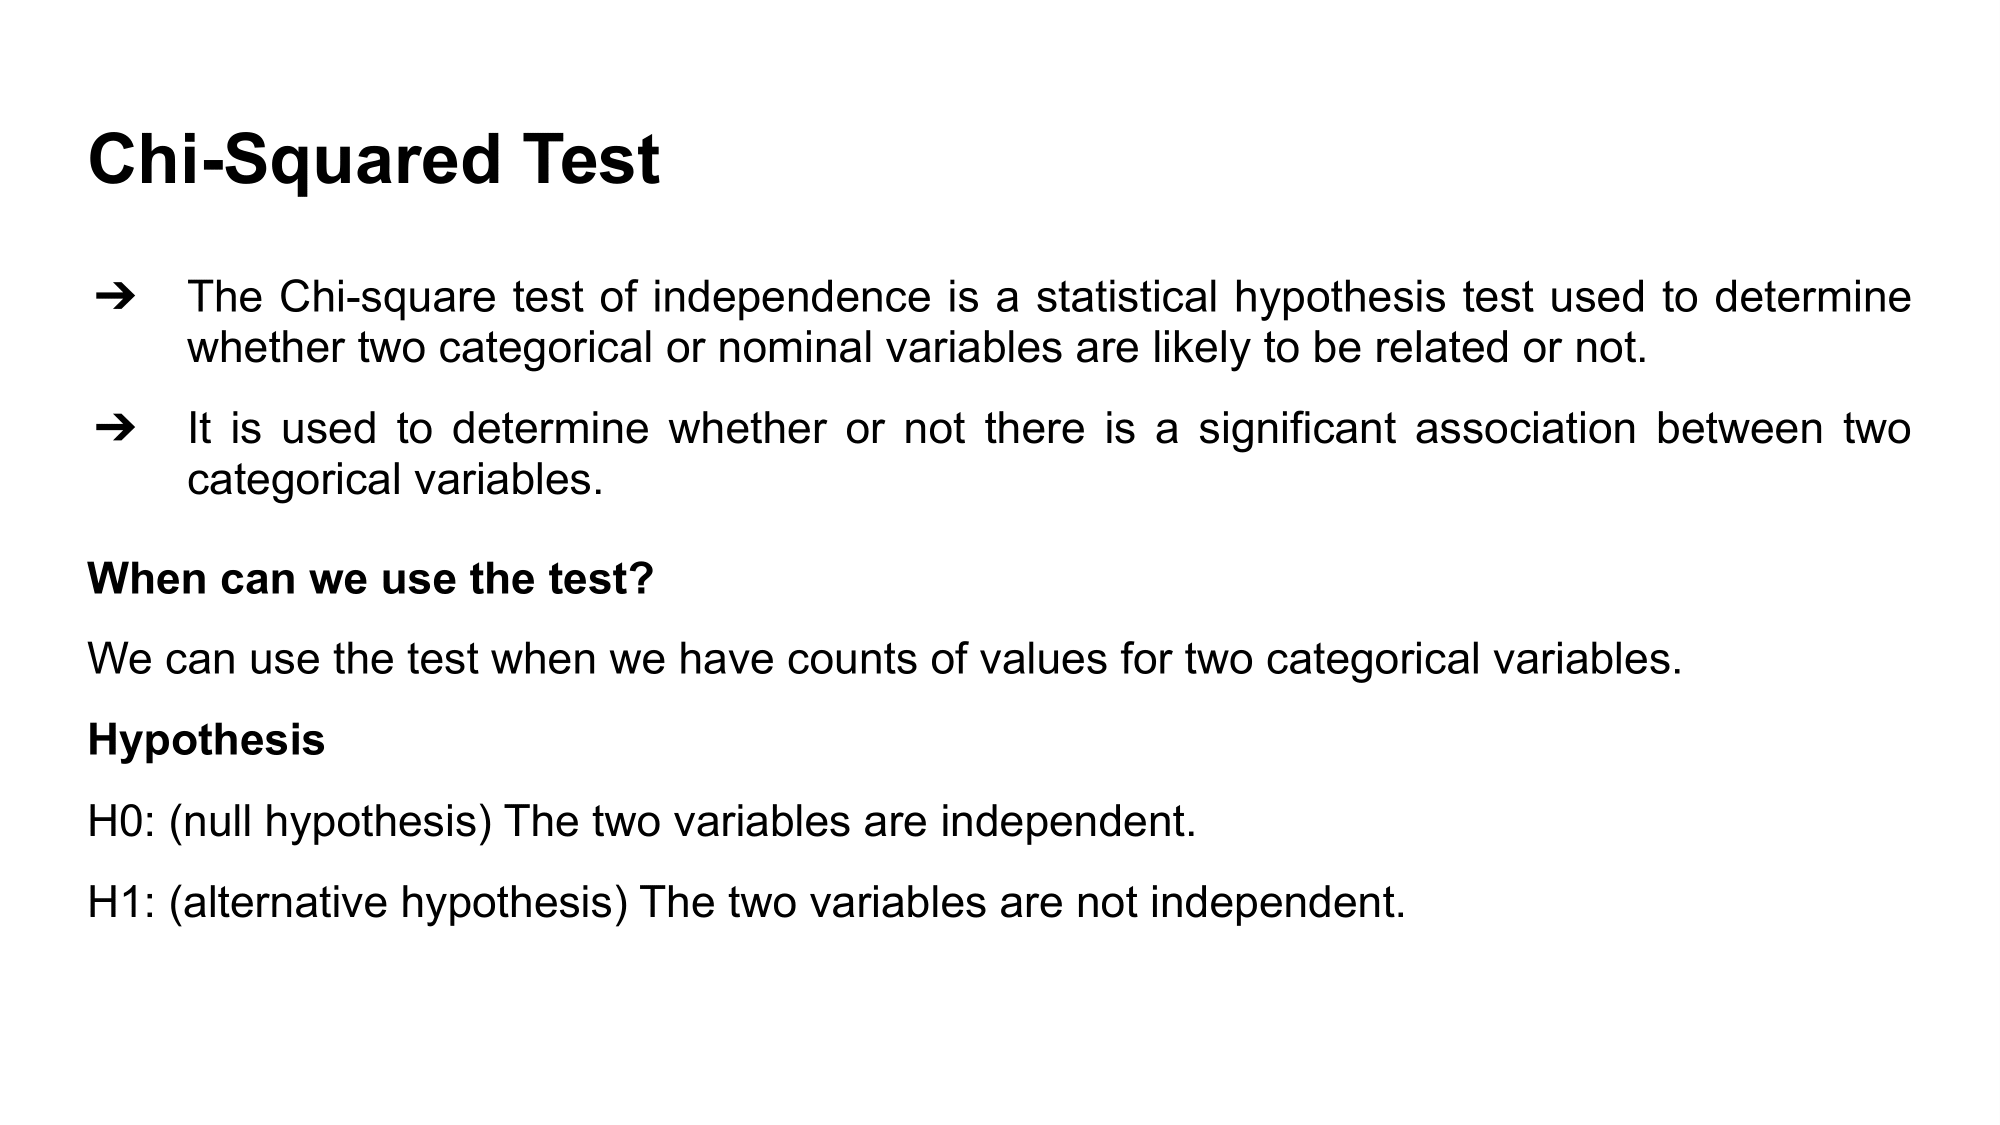

In [22]:
# Chi sq. Test
room = processed_df['roomcategory'].unique()
lst = {}
grouped = []
individual = []
for i in room[:-1]:
    grouped.append(processed_df.where(processed_df['poltype']=='Group').dropna()['roomcategory'].value_counts()[i])
        
    individual.append(processed_df.where(processed_df['poltype']=='Individual').dropna()['roomcategory'].value_counts()[i])

# for the Suite variable
grouped.append(processed_df.where(processed_df['poltype']=='Group').dropna()['roomcategory'].value_counts()['Suite'])
individual.append(0)

chi_df = [grouped,individual]
print(chi_df[0],chi_df[1],sep='\n')

[8575, 5225, 6525, 1751, 877, 2790, 1588, 12, 18, 26, 5, 31, 2]
[3950, 1204, 3503, 764, 347, 479, 340, 4, 4, 5, 4, 2, 0]


In [23]:
# perform the Chi-Square Test of Independence:
# H0: (null hypothesis) The two variables are independent.
# H1: (alternative hypothesis) The two variables are not independent.

test_stat, p_value, dof, arr = stats.chi2_contingency(chi_df)
print('Test statistic is %f'%float("{:.6f}".format(test_stat)))
print('p-value is %f'%p_value, end='\n')
print('degrees of freedom is', dof, end='\n\n' )
alpha = 0.05
if(p_value>=alpha):
    print('Conclusion:','Since the p-value: {:.2f} > or = alpha: {:.2f}, We fail to reject the null hypothesis.'.format(p_value,alpha),sep='\n')
else:
    print('Since the p-value: {:.2f} < alpha: {:.2f}, We reject the null hypothesis.'.format(p_value,alpha))

Test statistic is 1005.066565
p-value is 0.000000
degrees of freedom is 12

Since the p-value: 0.00 < alpha: 0.05, We reject the null hypothesis.


#### Insights:
> - Since we reject the null hypothesis, the two variables are not independent. To make the regression model better, we can use <code>Point-biserial correlation coefficient</code> or <code>Logistic Regression</code> to find the relation between the categorical independent variables and the continuous dependent variable.
> - We should use either of the two variables and to select which one, we use the above processes. The one with the higher relation with the dependent variable should be kept.
> - For the final step we should create dummies for the selected categorical column and run a regression analysis.

#### Chapters:
0: [A: Infectious and parasitic diseases,
    B: Infectious and parasitic diseases]

1: [O: Pregnancy and childbirth,
    R: Abnormal clinical and lab findings]

2: [C: Cancer, 
    G: Nervous system,
    <code>T: Injury, poisoning, and other external causes</code>]

3: [D: Neoplasms, blood, and blood-forming organs
    Q: Congenital and chromosomal abnormalities,
    <code>S: Injury, poisoning, and other external causes</code>]

4: [E: Endocrine, nutritional, or metabolic,
    <code>V: External causes of morbidity</code>
    Z: Factors influencing health status and contact with health services]

5: [F: Mental and behavioural disorders,
    P: Perinatal conditions,
    <code>W: External causes of morbidity, X: External causes of morbidity, Y: External causes of morbidity</code>]

6: [N: Genitourinary system,
    L: Skin]

7: [H: Eyes, ears, nose, and throat]

8: [I: Circulatory system]

9: [J: Respiratory system]

10: [K: Digestive system]

11: [M: Musculoskeletal system]

> Reference: https://www.verywellhealth.com/finding-icd-codes-2615311

In [24]:
%%time
processed_df.drop('ailmentcode',axis=1, inplace=True)
processed_df = pd.get_dummies(processed_df)

X = processed_df.drop(['clmapprovedamt','clmamtapproved_per'],axis=1)
y = processed_df['clmapprovedamt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1999)

RF = RandomForestRegressor()
RF.fit(X_train,y_train)
y_pred_1 = RF.predict(X_test)

print('MAE: {:.4f}'.format(mean_absolute_error(y_test,y_pred_1)), 
      'R2: {:.4f}'.format(r2_score(y_test,y_pred_1)), 
      'RMSE: {:.4f}'.format(sqrt(mean_squared_error(y_test,y_pred_1))), sep='\n\n')
r2_1 = r2_score(y_test,y_pred_1)

MAE: 21277.9052

R2: 0.6171

RMSE: 53266.5557
Wall time: 15.9 s


In [36]:
print('Actual number of columns present: ',processed_df.shape[1])

Actual number of columns present:  32


In [26]:
%%time
from sklearn.decomposition import PCA
pca = PCA(n_components=27)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

RF = RandomForestRegressor()
RF.fit(X_train_pca,y_train)
y_pred_2 = RF.predict(X_test_pca)

print('MAE: {:.4f}'.format(mean_absolute_error(y_test,y_pred_2)), 
      'R2: {:.4f}'.format(r2_score(y_test,y_pred_2)), 
      'RMSE: {:.4f}'.format(sqrt(mean_squared_error(y_test,y_pred_2))), sep='\n\n')
r2_2 = r2_score(y_test,y_pred_2)

MAE: 26440.8323

R2: 0.6139

RMSE: 53491.2962
Wall time: 1min 20s


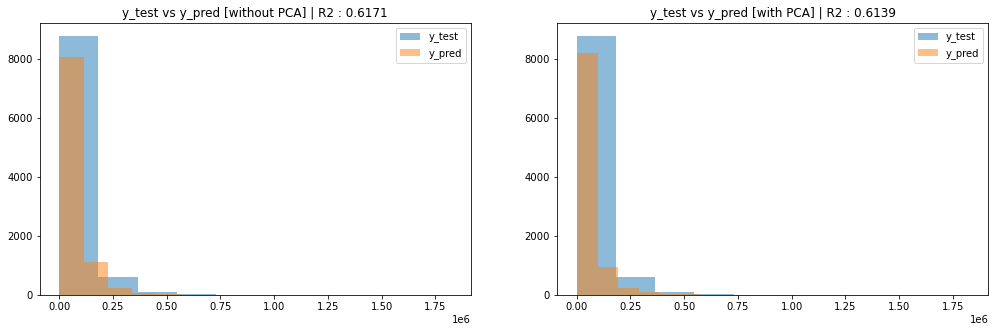

In [27]:
plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
plt.hist(y_test, 
         alpha=0.5,
         label='y_test')
  
plt.hist(y_pred_1,
         alpha=0.5,
         label='y_pred')
plt.legend(loc='upper right')
plt.title('y_test vs y_pred [without PCA] | R2 : {:.4f}'.format(r2_1))

plt.subplot(1,2,2)
plt.hist(y_test, 
         alpha=0.5,
         label='y_test')
  
plt.hist(y_pred_2,
         alpha=0.5,
         label='y_pred')
plt.legend(loc='upper right')
plt.title('y_test vs y_pred [with PCA] | R2 : {:.4f}'.format(r2_2))

plt.show()

#### Insights:
- Without PCA R2 score is near to the with PCA one and the total number of column reduction is only 5, which is too low.
- The overlaping shows that the without PCA model does a better job at creating the bins.
- Therefore we can say that it's best if we don't use PCA for this dataset.